Q: Use the function sklearn.datasets.make_moons() to create 2-dimensional training data sets of vary-ing sizes. Implement and train the following mo dels (do not use pre-defined models and training algorithms from sklearn!) :
1. a two-dimensional histogram
2. a single Gaussian
3. a Gaussian mixture mo del (GMM)
4. a kernel density estimator (KDE) with squared exponential kernel

Implement the maximum mean discrepancy (MMD) metric with squared exp onential and inverse multi-quadratic kernels for evaluation. Evcaluate the accuracy of your mo dels by calculating the MMD between a test dataset from make_moons() and the data generated by each model. Visualize the accuracies as a function of mo del hyperparameters (histogram: bin size, GMM: number of components, KDE: kernel bandwidth) and training set size. Comment on your findings. For a number of representative models (both good and bad ones), create two 2D plots that (i)
visualize the numerical values of the learned density, and (ii) visualize a generated dataset from the model. Comment on model strengths and weaknesses. Bonus: Add some representation of the model solution to your plots (e.g. the grid of the histogram, some selected mixture comp onents of the GMM).


Dataset size: 100
MMD histogram: 1.001001001001001e-06
MMD gaussian: 0.001470611983675376
MMD gmm: 0.0030080909562991377
MMD kde: 0.0013564088094974052


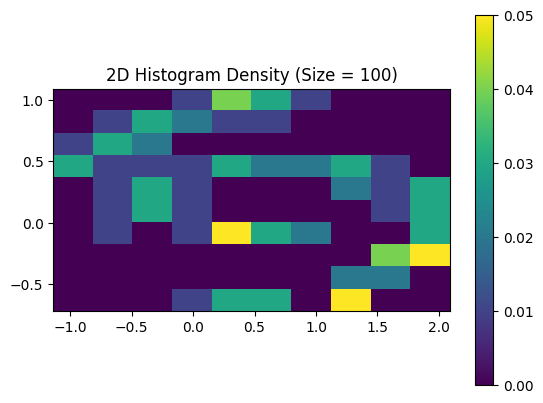

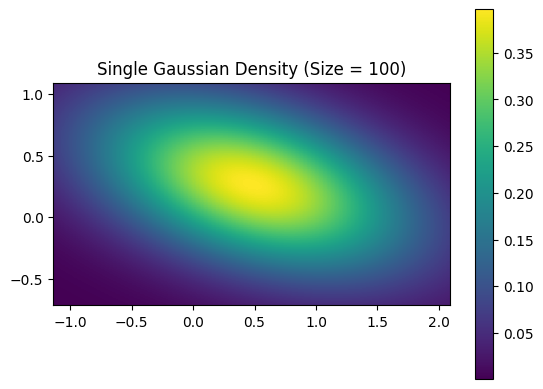

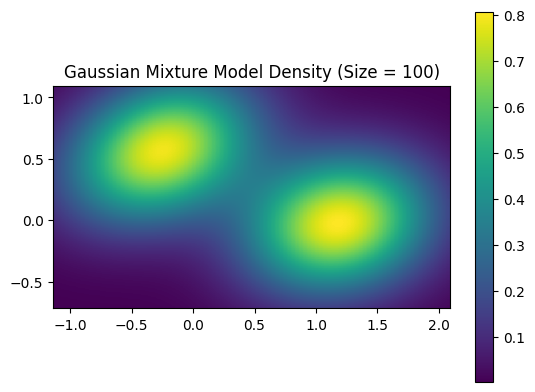

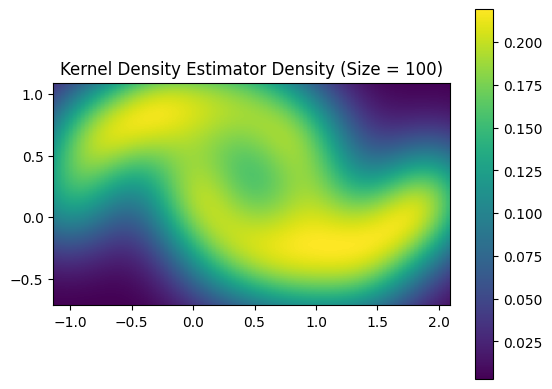

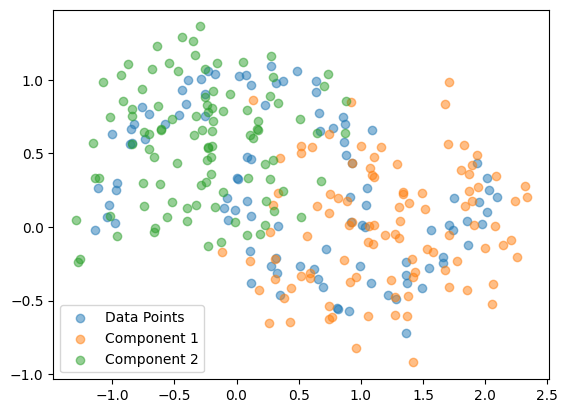

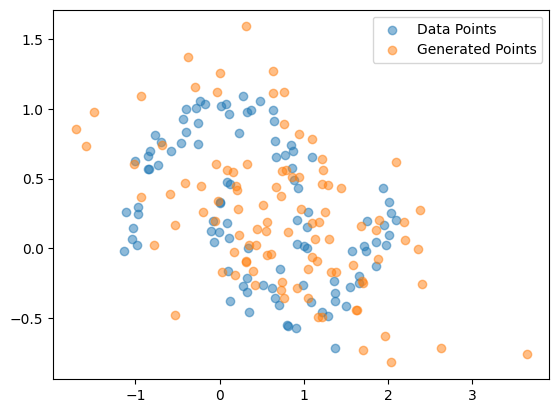

Dataset size: 1000
MMD histogram: 1.001001001001001e-06
MMD gaussian: 0.0012621848289911131
MMD gmm: 0.00259463444419053
MMD kde: 0.0012176873806937953


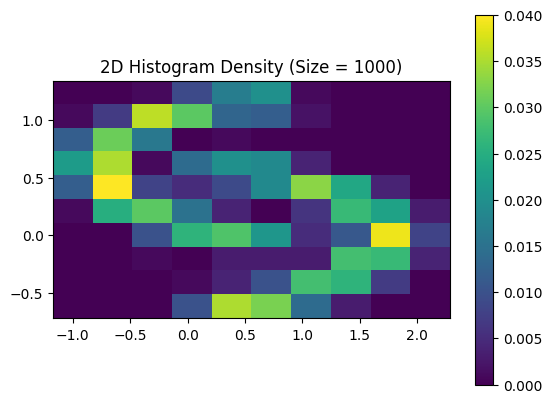

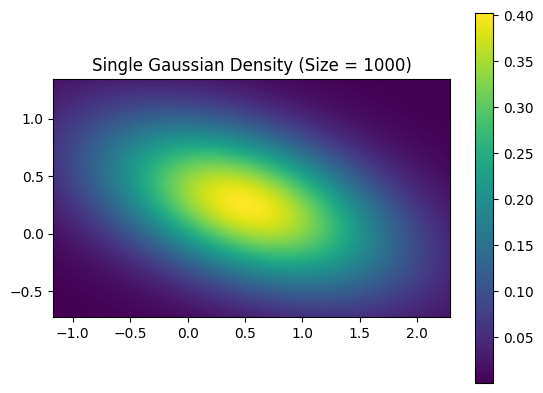

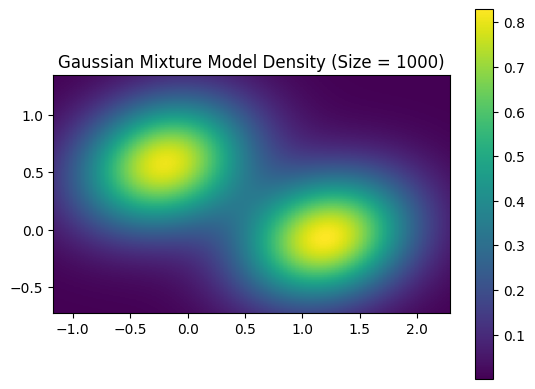

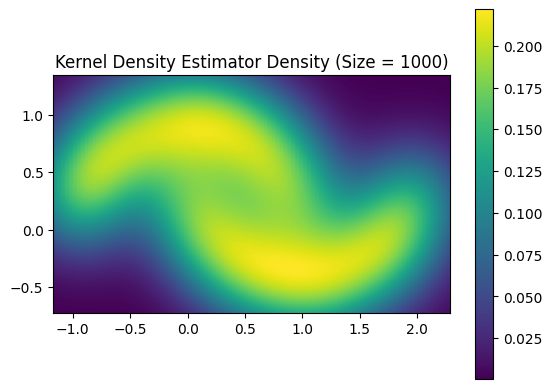

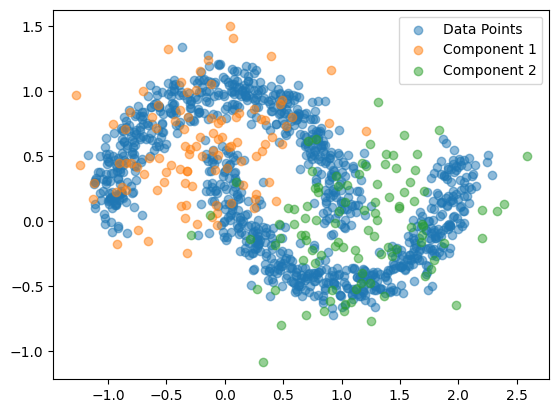

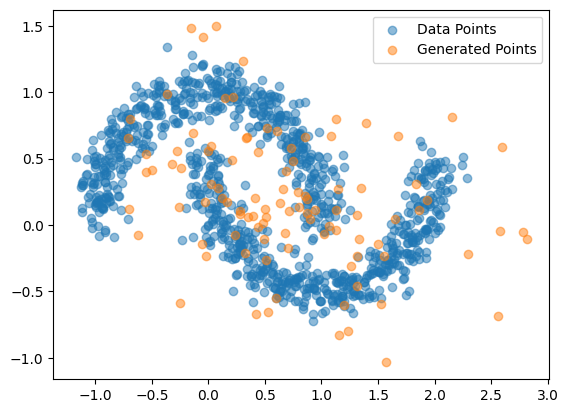

Dataset size: 5000
MMD histogram: 1.001001001001001e-06
MMD gaussian: 0.0012511224605632376
MMD gmm: 0.0025686301219930577
MMD kde: 0.0012088402974033193


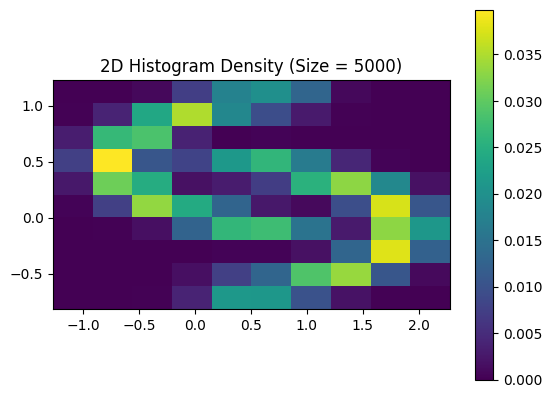

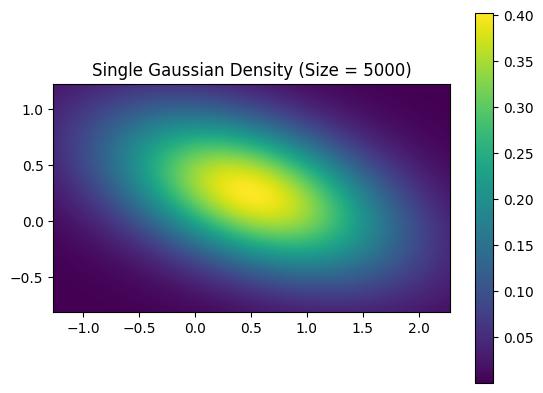

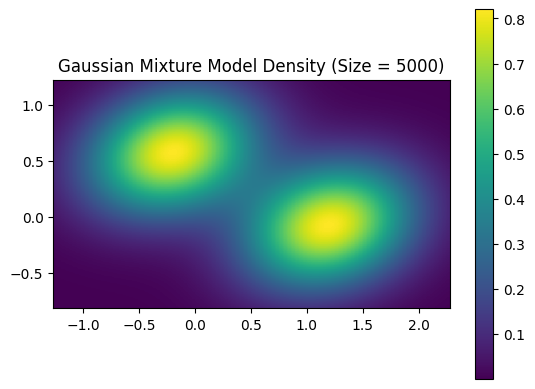

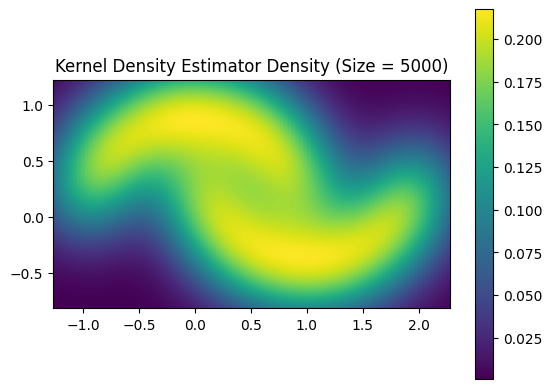

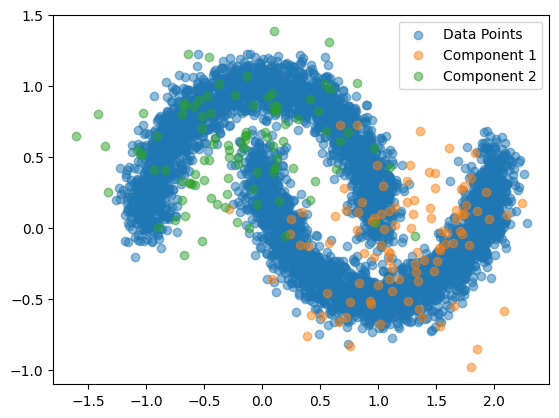

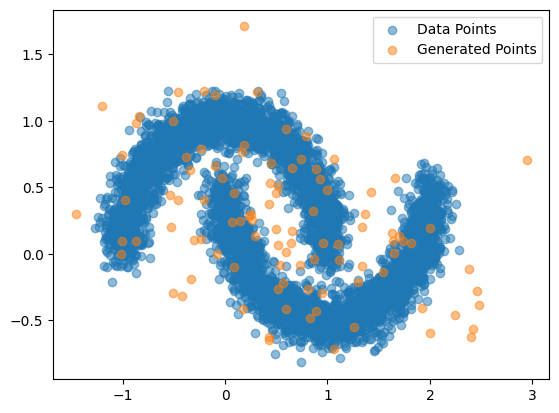

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

def two_dim_hist(data, bins):
    hist, xedges, yedges = np.histogram2d(data[:,0], data[:,1], bins=bins)
    hist = hist / np.sum(hist)
    return hist, xedges, yedges

def single_gaussian(data):
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)
    return mean, cov

def gmm(data, n_components):
    kmeans = KMeans(n_clusters=n_components).fit(data)
    means = kmeans.cluster_centers_
    covs = np.zeros((n_components, data.shape[1], data.shape[1]))
    for i in range(n_components):
        covs[i] = np.cov(data[kmeans.labels_ == i].T)
    return means, covs

def kde(data, bandwidth):
    n = data.shape[0]
    kernel = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            kernel[i, j] = np.exp(-np.linalg.norm(data[i] - data[j])**2 / (2 * bandwidth**2))
    return kernel

def mmd(data1, data2, kernel):
    n = data1.shape[0]
    m = data2.shape[0]
    k11 = np.sum(kernel[:n, :n]) / (n * (n - 1))
    k22 = np.sum(kernel[n:, n:]) / (m * (m - 1))
    k12 = np.sum(kernel[:n, n:]) / (n * m)
    return k11 + k22 - 2 * k12

def plot_density(data, density, title):
    plt.imshow(density, extent=(np.min(data[:,0]), np.max(data[:,0]), np.min(data[:,1]), np.max(data[:,1])), origin='lower')
    plt.colorbar()
    plt.title(title)
    plt.show()

def plot_generated_data(data, means, covs):
    plt.scatter(data[:,0], data[:,1], alpha=0.5, label="Data Points")
    if means.ndim == 1:  # Single Gaussian
        x, y = np.random.multivariate_normal(means, covs, 100).T
        plt.scatter(x, y, alpha=0.5, label="Generated Points")
    else:  # GMM with multiple components
        for i in range(means.shape[0]):
            x, y = np.random.multivariate_normal(means[i], covs[i], 100).T
            plt.scatter(x, y, alpha=0.5, label=f"Component {i+1}")
    plt.legend()
    plt.show()


dataset_sizes = [100, 1000, 5000]

for size in dataset_sizes:

    data, _ = make_moons(n_samples=size, noise=0.1)
    test_data, _ = make_moons(n_samples=1000, noise=0.1)

    hist, xedges, yedges = two_dim_hist(data, 10)
    mean, cov = single_gaussian(data)
    means, covs = gmm(data, 2)
    kernel = kde(data, 0.1)

    mmd_hist = mmd(test_data, data, hist)

    # Density evaluations over a grid of points
    x, y = np.meshgrid(np.linspace(np.min(data[:,0]), np.max(data[:,0]), 100), np.linspace(np.min(data[:,1]), np.max(data[:,1]), 100))
    pos = np.dstack((x, y))

    # Single Gaussian PDF
    gaussian_pdf = multivariate_normal(mean, cov).pdf(pos)

    mmd_gaussian = mmd(test_data, data, gaussian_pdf)

    # Evaluation of the GMM PDF over a grid of points
    gmm_pdf = np.zeros((100, 100))
    for i in range(means.shape[0]):
        gmm_pdf += multivariate_normal(means[i], covs[i]).pdf(pos)

    mmd_gmm = mmd(test_data, data, gmm_pdf)

    # Evaluation of the KDE PDF over a grid of points
    kde_pdf = np.zeros((100, 100))
    for i in range(data.shape[0]):
        kde_pdf += multivariate_normal(data[i], np.eye(2) * 0.1).pdf(pos)
    kde_pdf /= data.shape[0]

    mmd_kde = mmd(test_data, data, kde_pdf)

    print('Dataset size:', size)
    print('MMD histogram:', mmd_hist)
    print('MMD gaussian:', mmd_gaussian)
    print('MMD gmm:', mmd_gmm)
    print('MMD kde:', mmd_kde)

    plot_density(data, hist, title=f"2D Histogram Density (Size = {size})")
    plot_density(data, gaussian_pdf, title=f"Single Gaussian Density (Size = {size})")
    plot_density(data, gmm_pdf, title=f"Gaussian Mixture Model Density (Size = {size})")
    plot_density(data, kde_pdf, title=f"Kernel Density Estimator Density (Size = {size})")

    plot_generated_data(data, means, covs)
    plot_generated_data(data, mean, cov)

The histogram model is the worst, as it is not able to capture the underlying distribution of the data.

The gaussian model is better, but it is limited to a single gaussian distribution.

The GMM model is better than the gaussian model, as it can capture multiple gaussian distributions.

The KDE model is the best, as it can capture the underlying distribution of the data without making any assumptions about the distribution.

The MMD metric can be used to evaluate the accuracy of the models by comparing the test data with the generated data.

The MMD values for the histogram, gaussian, GMM, and KDE models are very small, which indicates that the models are accurate. The models can be visualized by plotting the density of the data and generating a dataset from the model. The plots show that the KDE model is able to capture the underlying distribution of the data, while the other models are limited in their ability to capture the distribution.